In [13]:
using PyCall
using PyPlot
using FFTW
using LinearAlgebra
using JLD2
using YAML
# FFTW.set_num_threads(16)

@pyimport mpl_toolkits.axes_grid1 as axgrid
plt.style.use("dark_background")
# plt.style.use("default")
plt.rc("font", family="STIXGeneral")
plt.rc("font", size=22)
plt.rc("mathtext", fontset="stix")

mpl = pyimport("matplotlib")
np = pyimport("numpy")

config = YAML.load_file("config.yaml")

Dict{Any, Any} with 12 entries:
  "subbox_buffer"      => 64
  "run_name"           => "TNG300-1_1024"
  "xmin"               => 0.0
  "num_scales"         => 10
  "output_directory"   => "../../../../output_files/"
  "nx"                 => 1024
  "snapshot_directory" => "../../../../global/cscratch1/sd/jialiu/NEXUS_TNG/300"
  "num_snaps"          => 4
  "snapfile_root"      => 99
  "algorithm"          => "NEXUS"
  "number_subboxes"    => 2
  "xmax"               => 205000.0

### Load Density Cube Data

In [6]:
output_dir = "../../../../output_files/"

@load output_dir*"99.jld2" den

print(np.shape(den))

(1024, 1024, 1024)

In [8]:
den_sub = den[1:512, 1:512,1:512]

512×512×512 Array{Float32, 3}:
[:, :, 1] =
 0.164515   0.0        0.972886   …  0.0        0.0         0.0
 0.0241716  0.219159   1.79951       0.0        0.0         0.0
 0.153413   2.38871    3.68746       0.0        0.00982262  1.31862
 0.124503   2.14765    0.586298      0.0        0.00328088  0.440438
 0.341669   2.24036    0.526099      0.0        0.0         0.0
 0.301784   1.36171    0.0        …  0.0        0.0         0.0
 0.0        0.0        1.96672       0.0        0.0         0.0
 0.0        0.0        1.02979       0.0        0.0         0.0
 0.0        0.0        0.0           0.460942   0.218619    0.0
 0.0        0.0        0.0           0.0542262  0.0257188   0.0
 0.0        0.424646   1.38357    …  0.0        0.0         0.0
 0.0        0.354632   1.15546       0.0        0.0625293   0.294462
 0.0775411  0.0        0.0           0.0        0.107306    0.505325
 ⋮                                ⋱             ⋮           
 0.0        0.0        0.0        …  0.0     

In [27]:
# utility function for plotting
function plot_square(arr; 
        xmin=config["xmin"], xmax=config["xmax"], 
        ax=nothing, vmin=1e-2, vmax=2,cmap="viridis", log_scale=true)
    if ax == nothing
        fig, ax = subplots(figsize=(9,9))
    end
    step = (xmax-xmin)/(size(arr)[1]+1)
    xg = collect( xmin+step/2:step:xmax-step )
    xyswapped = permutedims( arr, [2,1])
    if log_scale==true
        return ax[:pcolormesh](xg,xg, xyswapped, norm=mpl.colors.LogNorm(vmin=vmin, vmax=vmax),cmap=cmap) # in matplotlib, y is first
    else
        return ax[:pcolormesh](xg,xg, xyswapped, vmin=vmin, vmax=vmax,cmap=cmap)
    end
end

plot_square (generic function with 1 method)

### Test Log-Gaussian Smoothing

In [4]:
using CosmoMMF

In [38]:
wave_vecs = CosmoMMF.wavevectors3D(Float64,(512,512,512))
# print(typeof(wave_vecs))
density_field = den[1:512,1:512,1:512]
# print(density_field[128:156,128:156,256])
density_field=Float64.(density_field)
# print("\n\n\n")
# print(density_field[128:156,128:156,256])
density_field = density_field .+ 0.0001 #this is a bit of a temporary solution

print("Removing any 0.0 values in the density field.")

Removing any 0.0 values in the density field.

In [127]:
@time smoothed_TNG = CosmoMMF.smooth_loggauss(density_field, √2 , wave_vecs)
print("Smoothing Succesful")


 59.149548 seconds (186 allocations: 4.000 GiB, 0.52% gc time)
Smoothing Succesful

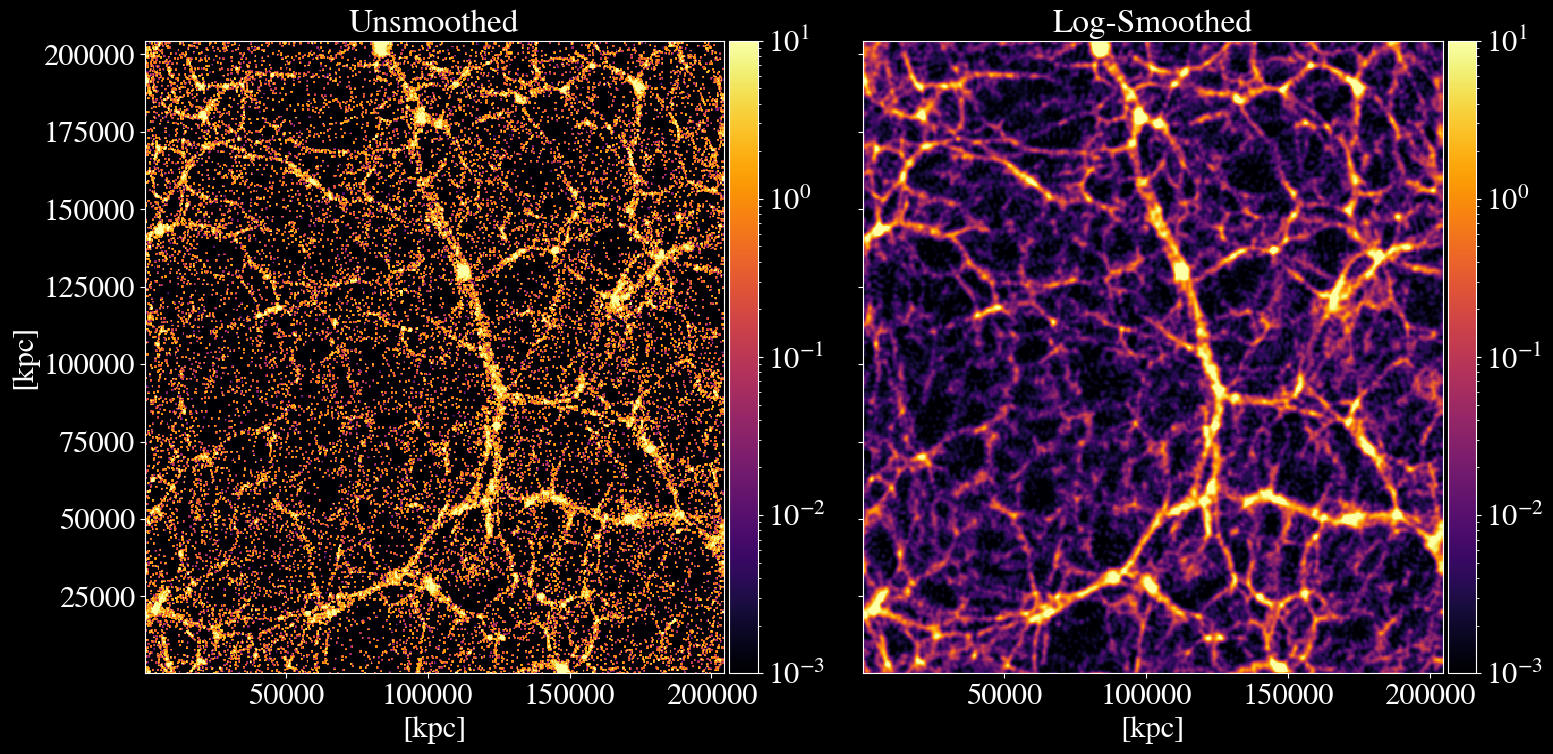

Yay! Log Gaussian Smoothing Works on TNG!

In [133]:


plt.style.use("dark_background")
# plt.style.use("default")
plt.rc("font", family="STIXGeneral")
plt.rc("font", size=22)
plt.rc("mathtext", fontset="stix")

f , (ax1,ax2) = plt.subplots(1,2, figsize=(16,8), sharey=true)
# f.suptitle("Density Fields - smoothed", fontsize=30)
#top left

im1 = plot_square(density_field[:,:,128], ax=ax1,cmap="inferno", vmin=1e-3, vmax=10)
ax1.set_title("Unsmoothed", fontsize=24)
ax1.set_xlabel("[kpc]")
ax1.set_ylabel("[kpc]")
divider1 = axgrid.make_axes_locatable(ax1)
cax1 = divider1.append_axes("right", size="5%", pad=0.05)
f.colorbar(im1, cax=cax1)
#top right

im2 = plot_square(smoothed_TNG[:,:,128], ax=ax2,cmap="inferno",vmin=1e-3, vmax=10)
ax2.set_title("Log-Smoothed", fontsize=24)
ax2.set_xlabel("[kpc]")
divider2 = axgrid.make_axes_locatable(ax2)
cax2 = divider2.append_axes("right", size="5%", pad=0.05)
f.colorbar(im2, cax=cax2)
# ax2.set_ylabel("[kpc]", fontsize=18)

f.tight_layout()
# plt.savefig("../../../../Images/Smoothing_Comparison.png", format="png", dpi=300, bbox_inches="tight")
plt.show()

print("""Yay! Log Gaussian Smoothing Works on TNG!""")


### Test Calculation of the Hessian

In [135]:
@time Hessian_TNG = CosmoMMF.hessian_from_smoothed(smoothed_TNG, √2 , wave_vecs)

print("Hessian Computed!")

151.328209 seconds (2.52 M allocations: 58.129 GiB, 1.84% gc time)


512×512×512×6 Array{Float64, 4}:
[:, :, 1, 1] =
  0.0386777     0.0608455    0.0671321   …   0.01021       0.0205803
 -0.00172478    0.00616843  -0.00185618      0.000396517  -0.00141302
 -0.0810682    -0.13281     -0.145069       -0.0207907    -0.0423957
 -0.00881859   -0.0550757   -0.0491565      -0.000782187   0.00376094
  0.0316121     0.0344825    0.0338002       0.0105738     0.0187493
  0.0180765     0.0328685    0.0179405   …   0.00348625    0.00765629
  0.0086203     0.0205899    0.00911008      0.00241298    0.00296255
  0.00556592    0.0138515    0.02089        -0.000325837   0.00201254
  0.00469821    0.00910905   0.0146467       0.00186089    0.00226361
  0.00452803    0.00540397   0.00577701      0.000630314   0.0030076
  0.00120841   -0.00317268  -0.0032809   …   0.00526464    0.00392236
 -0.00464463   -0.00495026  -0.00161867     -0.00247663   -0.00341762
 -0.0116113    -0.00479741   0.00101564     -0.00506062   -0.0117268
  ⋮                                      ⋱   ⋮ 

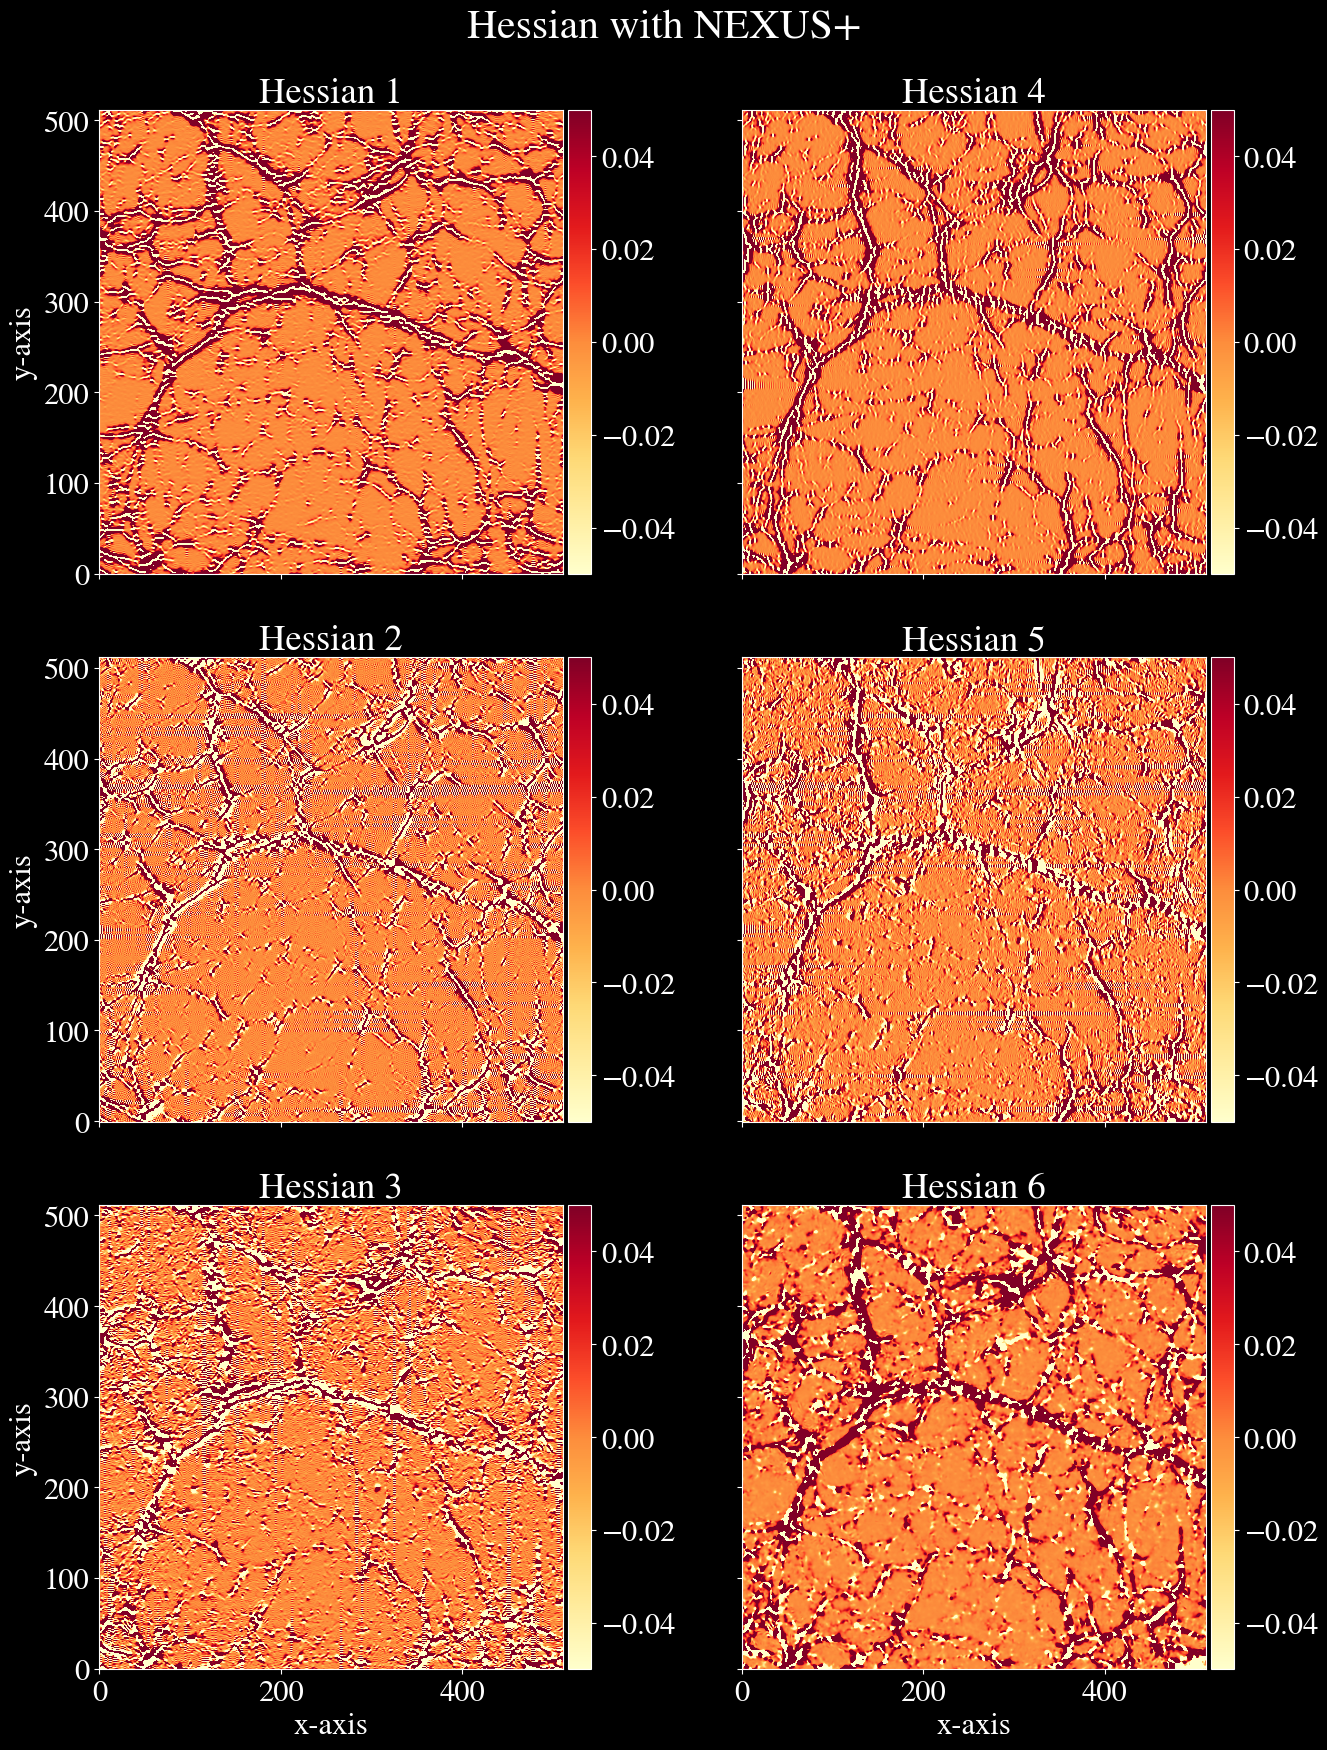

In [186]:
f, (ax1, ax2,ax3,ax4,ax5,ax6) = plt.subplots(3,2, figsize=(14,18),sharex=true, sharey=true)
f.suptitle("Hessian with NEXUS+", fontsize=30)
#top left

#plot_square(Hessian_TNG[:,:,128,1], ax=ax1)
#ax1.imshow(Hessian_TNG[:,:,128,1], origin="lower", vmin=-0.05, vmax=0.05)
ax1.set_title("Hessian 1")
# ax1.set_xlabel("x-axis")
ax1.set_ylabel("y-axis")
im1 = ax1.imshow(Hessian_TNG[:,:,128,1], origin="lower",cmap="YlOrRd", vmin=-0.05, vmax=0.05)
divider1 = axgrid.make_axes_locatable(ax1)
cax1 = divider1[:append_axes]("right", size="5%", pad=0.05)
f.colorbar(im1, cax=cax1)
#top middle

#plot_square(Hessian_TNG[:,:,128,2], ax=ax2)
# ax2.imshow(Hessian_TNG[:,:,128,2], origin="lower")
ax2.set_title("Hessian 2")
# ax2.set_xlabel("x-axis")
ax2.set_ylabel("y-axis")
im2 = ax2.imshow(Hessian_TNG[:,:,128,2], origin="lower",cmap="YlOrRd", vmin=-0.05, vmax=0.05)
divider2 = axgrid.make_axes_locatable(ax2)
cax2 = divider2[:append_axes]("right", size="5%", pad=0.05)
f.colorbar(im2, cax=cax2)
#top right

#plot_square(Hessian_TNG[:,:,128,3], ax=ax3)
# ax3.imshow(Hessian_TNG[:,:,128,3], origin="lower")
ax3.set_title("Hessian 3")
ax3.set_xlabel("x-axis")
ax3.set_ylabel("y-axis")
im3 = ax3.imshow(Hessian_TNG[:,:,128,3], origin="lower",cmap="YlOrRd", vmin=-0.05, vmax=0.05)
divider3 = axgrid.make_axes_locatable(ax3)
cax3 = divider3[:append_axes]("right", size="5%", pad=0.05)
f.colorbar(im3, cax=cax3)

#left

#plot_square(Hessian_TNG[:,:,128,4], ax=ax4)
# ax4.imshow(Hessian_TNG[:,:,128,4], origin="lower")
ax4.set_title("Hessian 4")
# ax4.set_xlabel("x-axis")
# ax4.set_ylabel("y-axis")
im4 = ax4.imshow(Hessian_TNG[:,:,128,4], origin="lower", cmap="YlOrRd",vmin=-0.05, vmax=0.05)
divider4 = axgrid.make_axes_locatable(ax4)
cax4 = divider4[:append_axes]("right", size="5%", pad=0.05)
f.colorbar(im4, cax=cax4)
#middle

#plot_square(Hessian_TNG[:,:,128,5], ax=ax5)
# ax5.imshow(Hessian_TNG[:,:,128,5], origin="lower")
ax5.set_title("Hessian 5")
# ax5.set_xlabel("x-axis")
# ax5.set_ylabel("y-axis")
im5 = ax5.imshow(Hessian_TNG[:,:,128,5], origin="lower", cmap="YlOrRd",vmin=-0.05, vmax=0.05)
divider5 = axgrid.make_axes_locatable(ax5)
cax5 = divider5[:append_axes]("right", size="5%", pad=0.05)
f.colorbar(im5, cax=cax5)
#right

#plot_square(Hessian_TNG[:,:,128,6], ax=ax6)
# ax6.imshow(Hessian_TNG[:,:,128,6])
ax6.set_title("Hessian 6")
ax6.set_xlabel("x-axis")
# ax6.set_ylabel("y-axis")
im6 = ax6.imshow(Hessian_TNG[:,:,128,6], origin="lower", cmap="YlOrRd",vmin=-0.05, vmax=0.05)
divider6 = axgrid.make_axes_locatable(ax6)
cax6 = divider6[:append_axes]("right", size="5%", pad=0.05)
f.colorbar(im6, cax=cax6)
f.tight_layout()
# plt.savefig("../../../../Images/Hessian_slices.png", format="png", dpi=300, bbox_inches="tight")

### Testing Signature Calculation

In [258]:
print(size(Hessian_TNG), "\n")
print(typeof(Hessian_TNG), "\n")
print(typeof(wave_vecs), "\n")

(512, 512, 512, 6)
Array{Float64, 4}
Tuple{Frequencies{Float64}, Frequencies{Float64}, Frequencies{Float64}}


In [172]:
@time signatures_TNG = CosmoMMF.signatures_from_hessian(Hessian_TNG)

print("Signatures Calculated!")

 87.634564 seconds (1.12 M allocations: 3.063 GiB, 0.06% gc time, 0.65% compilation time)
Signatures Calculated!

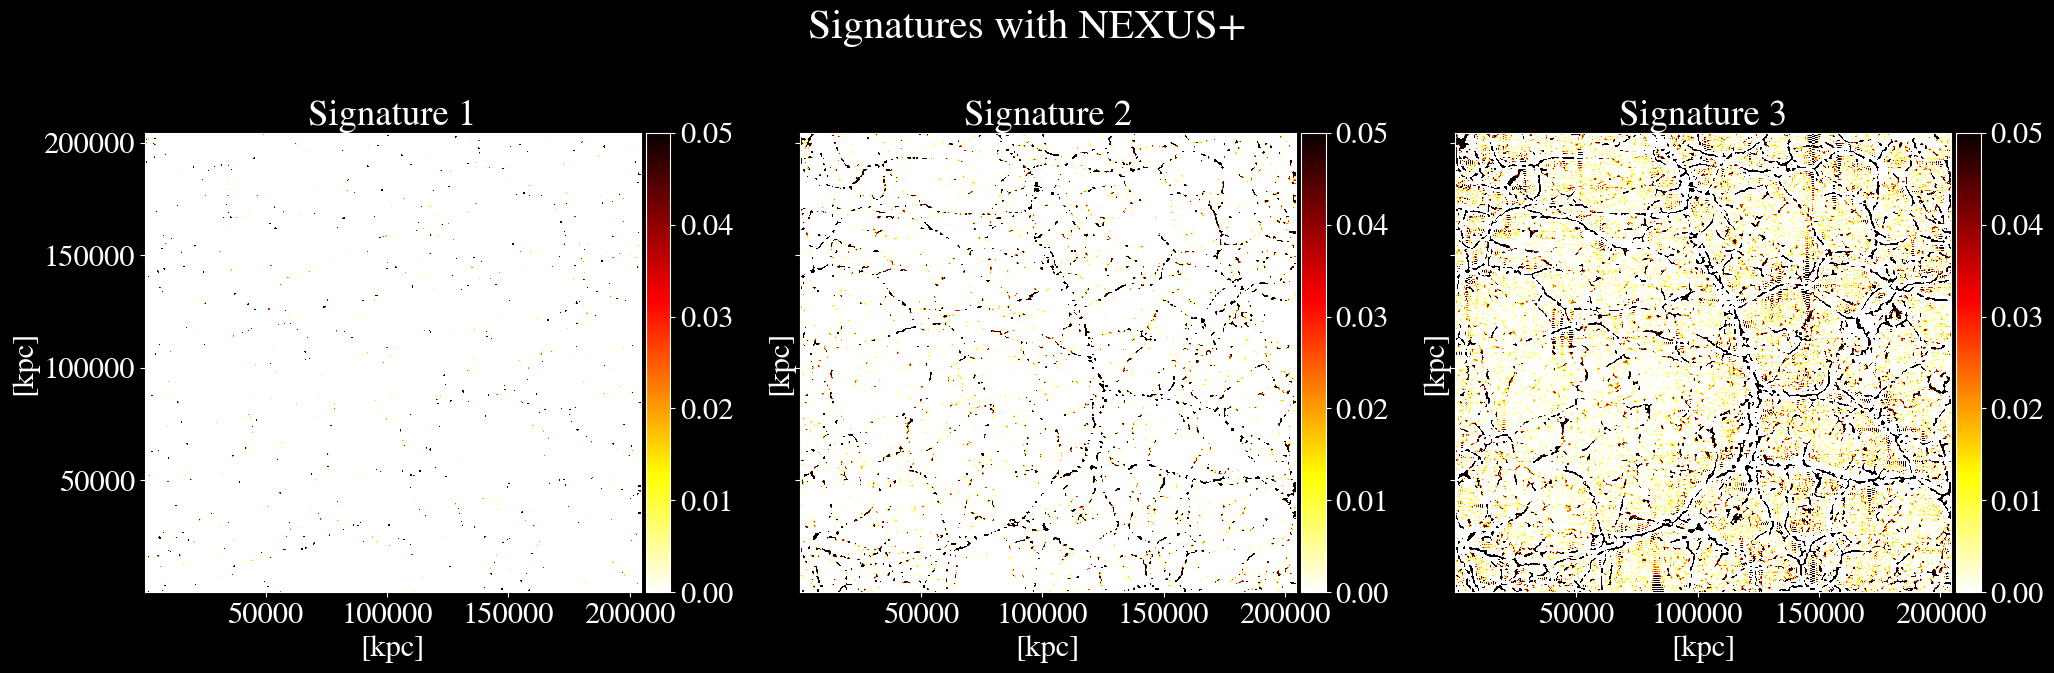

In [220]:

plt.style.use("dark_background")
# plt.style.use("default")
plt.rc("font", family="STIXGeneral")
plt.rc("font", size=22)
plt.rc("mathtext", fontset="stix")

f, (ax1,ax2,ax3) = plt.subplots(1,3,figsize=(21,7), sharey=true)
f.suptitle("Signatures with NEXUS+", fontsize=30)
#top left
#plot_square(Hessian_TNG[:,:,128,1], ax=ax1)
im1 = plot_square(signatures_TNG[:,:,128,1], ax=ax1,cmap="hot_r",vmin=0, vmax=0.05, log_scale=false)
ax1.set_title("Signature 1")
ax1.set_xlabel("[kpc]")
ax1.set_ylabel("[kpc]")
divider1 = axgrid.make_axes_locatable(ax1)
cax1 = divider1[:append_axes]("right", size="5%", pad=0.05)
plt.colorbar(im1, cax=cax1)
#top middle

#plot_square(Hessian_TNG[:,:,128,2], ax=ax2)
im2 = plot_square(signatures_TNG[:,:,128,2], ax=ax2,cmap="hot_r",vmin=0, vmax=0.05, log_scale=false)
ax2.set_title("Signature 2")
ax2.set_xlabel("[kpc]")
ax2.set_ylabel("[kpc]")
divider2 = axgrid.make_axes_locatable(ax2)
cax2 = divider2[:append_axes]("right", size="5%", pad=0.05)
plt.colorbar(im2, cax=cax2)
#top right

#plot_square(Hessian_TNG[:,:,128,3], ax=ax3)
im3 = plot_square(signatures_TNG[:,:,128,3], ax=ax3,cmap="hot_r",vmin=0, vmax=0.05, log_scale=false)
ax3.set_title("Signature 3")
ax3.set_xlabel("[kpc]")
ax3.set_ylabel("[kpc]")
divider3 = axgrid.make_axes_locatable(ax3)
cax3 = divider3[:append_axes]("right", size="5%", pad=0.05)
plt.colorbar(im3, cax=cax3)
plt.tight_layout()
plt.savefig("../../../../Images/signature_values_dark.png", format="png", dpi=300, bbox_inches="tight")

# Testing of full algorithm

In [57]:
den_sub = den[1:512, 1:512, 1:512]
den_sub = Float64.(den_sub)

Rs = (√2) .^ (0:10)
print("loading different scales")

loading different scales

In [7]:
@time combined_NEXUS = CosmoMMF.maximum_signature(Rs, den_sub; alg=:NEXUS);
CosmoMMF.save_max_sigs(output_dir, "Sigs_Nexus_99", combined_NEXUS)
# combined_NEXUS = nothing

3423.283559 seconds (11.56 M allocations: 796.641 GiB, 1.61% gc time)


In [15]:
@time combined_NEXUSPLUS = CosmoMMF.maximum_signature(Rs, den_sub; alg=:NEXUSPLUS);
CosmoMMF.save_max_sigs(output_dir, "Sigs_NexusPlus_99", combined_NEXUSPLUS)
# combined_NEXUSPLUS = nothing

3573.083081 seconds (13.63 M allocations: 719.759 GiB, 1.33% gc time)


In [25]:
combined_NEXUS = load(output_dir * "Sigs_Nexus_99.jld2")
combined_NEXUSPLUS = load(output_dir * "Sigs_NexusPlus_99.jld2")

combined_NEXUSPLUS = combined_NEXUSPLUS["sig_array"]
combined_NEXUS = combined_NEXUS["sig_array"]
print("succesful loading")

succesful loading

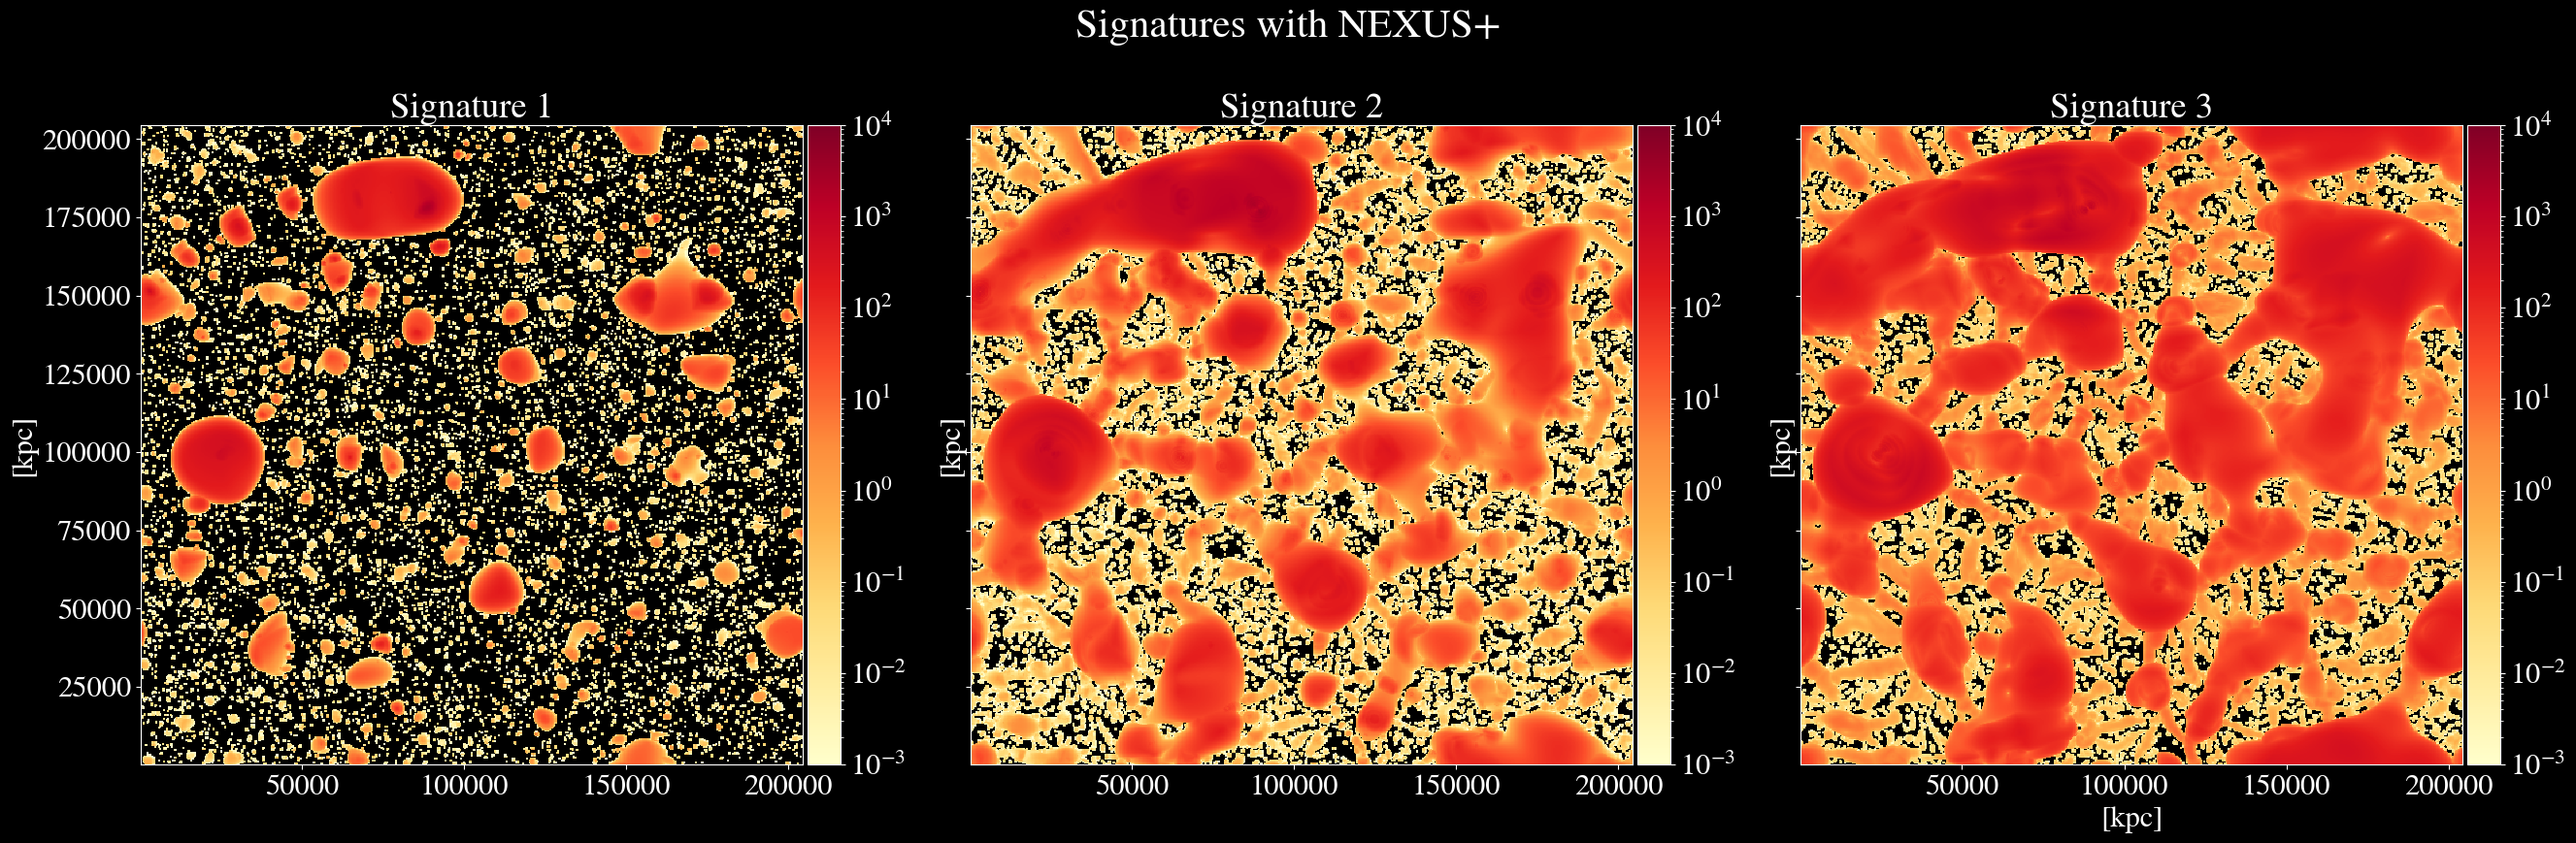

In [68]:

plt.style.use("dark_background")
# plt.style.use("default")
plt.rc("font", family="STIXGeneral")
plt.rc("font", size=22)
plt.rc("mathtext", fontset="stix")

f, (ax1,ax2,ax3) = plt.subplots(1,3,figsize=(27,9), sharey=true, sharex=true)
f.suptitle("Signatures with NEXUS+", fontsize=30)

#top left
im1 = plot_square(combined_NEXUS[:,:,420,1], ax=ax1,cmap="YlOrRd",vmin=0.001, vmax=10000, log_scale=true)
ax1.set_title("Signature 1")
# ax1.set_xlabel("[kpc]")
ax1.set_ylabel("[kpc]")
divider1 = axgrid.make_axes_locatable(ax1)
cax1 = divider1[:append_axes]("right", size="5%", pad=0.05)
plt.colorbar(im1, cax=cax1)

#top middle

im2 = plot_square(combined_NEXUS[:,:,420,2], ax=ax2,cmap="YlOrRd",vmin=0.001, vmax=10000, log_scale=true)
ax2.set_title("Signature 2")
# ax2.set_xlabel("[kpc]")
ax2.set_ylabel("[kpc]")
divider2 = axgrid.make_axes_locatable(ax2)
cax2 = divider2[:append_axes]("right", size="5%", pad=0.05)
plt.colorbar(im2, cax=cax2)
#top right

im3 = plot_square(combined_NEXUS[:,:,420,3], ax=ax3,cmap="YlOrRd",vmin=0.001, vmax=10000, log_scale=true)
ax3.set_title("Signature 3")
ax3.set_xlabel("[kpc]")
ax3.set_ylabel("[kpc]")
divider3 = axgrid.make_axes_locatable(ax3)
cax3 = divider3[:append_axes]("right", size="5%", pad=0.05)
plt.colorbar(im3, cax=cax3)
plt.tight_layout()
# plt.savefig("../../../../Images/NEXUSPLUS_512_RESULT.png", format="png", dpi=300, bbox_inches="tight")

In [25]:
# We save the maximum signatures in a jld2 file because it takes the longest
#to compute

# @save output_dir * "99" * "_max_sigs_" * ".jld2" combined_NEXUSPLUS


CosmoMMF.save_max_sigs(output_dir, "testing", combined_NEXUSPLUS)

### Cluster Detection

In [9]:
############################################################
# TNG-300-3-Dark specifications (From Illustris website)
############################################################
# TNG300-3-Dark specifications
DM_particle_mass = 0.302538487429177 # in units of 1e10 Msun/h
N_DM = 244140625/8
N_cells = size(den_sub,1) * size(den_sub,2) * size(den_sub,3)
# an average grid cell has 
mass_of_average_cell = DM_particle_mass * N_DM / N_cells


# ############################################################
# # TNG-300-3 specifications (From Illustris website)
# ############################################################
# # TNG300-3 specifications
# DM_particle_mass = 0.302538487429177 # in units of 1e10 Msun/h
# N_DM = 244140625
# N_cells = size(den,1) * size(den,2) * size(den,3)
# # an average grid cell has 
# mass_of_average_cell = DM_particle_mass * N_DM / N_cells

0.06878928784980803

In [10]:
using Images

function get_clusbools(thresh, max_cats::AbstractArray{T,4}) where T
    # step 1. create a bool filter that is only true when 
    # cluster signatures are larger than threshold
    test_bools = (max_cats[:,:,:,1] .> thresh)
    
    nx, ny, nz = size(max_cats)[1:3]

    # step 2. tag components
    components = Images.label_components(test_bools)
    max_component = maximum(components)

    print("Components: $(max_component)\n")
    
    # step 3. loop through each component, assess average overdensity
    masses = zeros(T, max_component)
    volume = zeros(T, max_component)

    compare = zeros(nx,nx,nx);

    for i in 1:nx
        for j in 1:nx
            for k in 1:nx
                if components[i,j,k] != 0
                    masses[ components[i,j,k] ] += den[i,j,k]
                    volume[ components[i,j,k] ] += 1.0
                end
            end
        end
    end
    
    compbool = (masses .> 5e3 / mass_of_average_cell)  .& (volume .> 1)
    println( "viri frac: ", sum( (volume .> 1) .& (masses ./ volume .> 370) ) / max_component)
    println( "mass frac: ", sum(masses[compbool])   / sum(den) )
    
    clusbool = zeros(Bool, nx, nx, nx)
    for i in 1:nx
        for j in 1:ny
            for k in 1:nz
                if components[i,j,k] != 0
                    if compbool[components[i,j,k]]
                        clusbool[i,j,k] = true
                    end
                end
            end
        end
    end
    
    clusbool
end

get_clusbools (generic function with 1 method)

In [16]:
@load "../../../../output_files/Sigs_Nexus_99.jld2" combined_NEXUS
@load "../../../../output_files/Sigs_NexusPlus_99.jld2" combined_NEXUSPLUS

LoadError: KeyError: key "combined_NEXUS" not found

In [62]:
clusbool = get_clusbools(240.0, combined_NEXUS);

Components: 498
viri frac: 0.5481927710843374
mass frac: 0.017345831766382422


In [63]:
# we create 3 N^3 arrays with the signature corresponding to each structure
cluster_signature = reshape(combined_NEXUS[:,:,:,1], N_cells)
filament_signature = reshape(combined_NEXUSPLUS[:,:,:,2], N_cells)
wall_signature = reshape(combined_NEXUSPLUS[:,:,:,3], N_cells);

In [64]:
function get_sig_plot(sig_vec, f)
    log10S = collect(-2:0.2:3) #this just makes an array [-2.0, -1.8, -1.6, ... , 2.8, 3.0]
    yy = zeros(Float64, size(log10S))
    for i in 1:size(yy,1)
        yy[i] = sum(
            f[sig_vec .> (10^log10S[i])]
            ) 
    end
    
    dydx = abs.( diff(yy.^2) ./ diff( log10S ) );
    midx = (log10S[1:size(log10S,1)-1] .+ log10S[2:size(log10S,1)]) ./ 2;
    return (10 .^ midx), dydx
end

not_clus_flat = reshape( clusbool .== false, N_cells ); #bool array that is false where there are clusters
filament_valid = filament_signature[ not_clus_flat ];
flat_den_valid = reshape(den_sub, N_cells)[ not_clus_flat ];

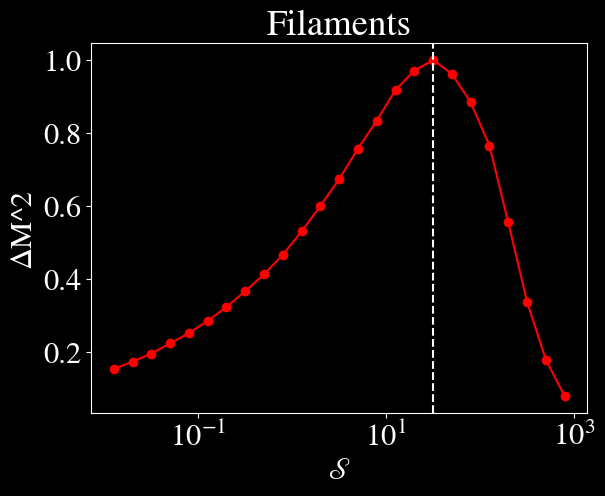

In [69]:
S_fil, dM2_fil = get_sig_plot(filament_valid, flat_den_valid)
max_dM, ind = findmax(dM2_fil)
filament_thresh = S_fil[ind]
plt.plot(S_fil, dM2_fil ./ maximum(dM2_fil), "ro")
plt.plot(S_fil, dM2_fil ./ maximum(dM2_fil), "r-")
plt.axvline(filament_thresh, color="white", linestyle="--")
plt.title("Filaments")
plt.ylabel("ΔM^2")
plt.xlabel("𝒮")
plt.xscale("log")


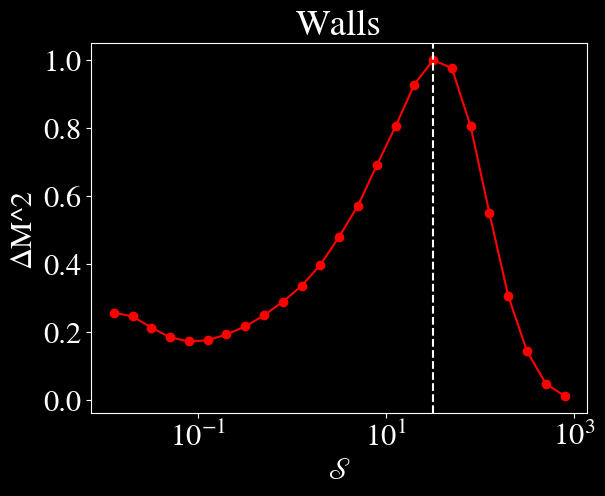

PyObject <matplotlib.lines.Line2D object at 0x2aab26243710>

In [70]:
wall_valid_filt = (not_clus_flat) .& (filament_signature .< filament_thresh)
wall_valid = wall_signature[wall_valid_filt];
wall_den_valid = reshape(den_sub, N_cells)[wall_valid_filt];

S_wall, dM2_wall = get_sig_plot(wall_valid, wall_den_valid)
max_dM, ind = findmax(dM2_wall)
wall_thresh = S_wall[ind]
plt.plot(S_wall, dM2_wall ./ maximum(dM2_wall), "ro")
plt.plot(S_wall, dM2_wall ./ maximum(dM2_wall), "r-")
plt.xscale("log")
plt.title("Walls")
plt.ylabel("ΔM^2")
plt.xlabel("𝒮")
plt.axvline(wall_thresh, color="white", linestyle="--")

In [71]:
cluster = den_sub[clusbool]
filbool = (combined_NEXUSPLUS[:,:,:,2] .> filament_thresh) .& (.!clusbool)
filament = den_sub[filbool]
wallbool = (combined_NEXUSPLUS[:,:,:,3] .> wall_thresh) .& .!(filbool .| clusbool)
wall = den_sub[wallbool];

total_mass = sum(den_sub)
println(sum(cluster) / total_mass)
println(sum(filament) / total_mass)
println(sum(wall) / total_mass)

0.14334876221369872
0.45782279795297154
0.21927008476704088


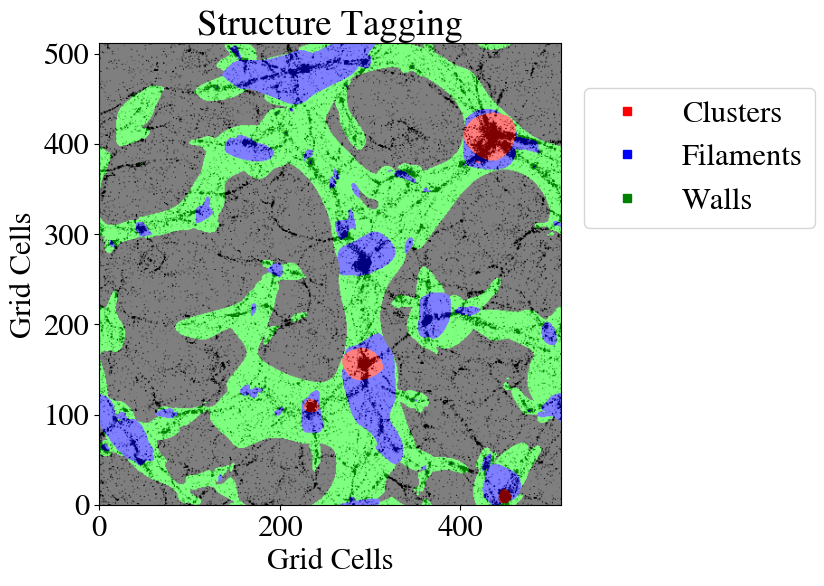

In [78]:
# plt.style.use("dark_background")
plt.style.use("default")
plt.rc("font", family="STIXGeneral")
plt.rc("font", size=22)
plt.rc("mathtext", fontset="stix")

fig, ax = subplots(1,1,figsize=(6,6))

slice = 256
densq = -clamp.(den_sub[:,:,slice], 0, 3)/3 .+ 1 # density plot
densq ./= 2
ax.set_title("Structure Tagging")
ax.set_xlabel("Grid Cells")
ax.set_ylabel("Grid Cells")

ax.imshow(  cat( [
            transpose(clamp.(densq + (clusbool[:,:,slice])[:,:,1] / 2, 0.0,1.0)), 
            transpose(clamp.(densq + wallbool[:,:,slice] / 2, 0.0,1.0)),
            transpose(clamp.(densq + filbool[:,:,slice] / 2, 0.0,1.0))]..., dims=3) , origin="lower" )

plt.axvline()

plt.plot([],[],"rs", label="Clusters")
plt.plot([],[], "bs", label="Filaments")
plt.plot([],[], "gs", label="Walls")
plt.legend(loc=(1.05,0.6))
plt.savefig("../../../../Images/NEXUSPLUS_512_all_components.png", format="png", dpi=300, bbox_inches="tight")

In [3]:
f, (ax1,ax2) = plt.subplots(1,2, figsize=(12,6))

ax1.plot(S_fil, dM2_fil ./ maximum(dM2_fil), "ro")
ax1.plot(S_fil, dM2_fil ./ maximum(dM2_fil), "r-")
ax1.axvline(filament_thresh, color="white", linestyle="--")
ax1.set_title("Filaments")
ax1.set_ylabel("ΔM^2")
ax1.set_xlabel("𝒮")
ax1.set_xscale("log")

ax2.plot(S_wall, dM2_wall ./ maximum(dM2_wall), "ro")
ax2.plot(S_wall, dM2_wall ./ maximum(dM2_wall), "r-")
ax2.xscale("log")
ax2.set_title("Walls")
ax2.set_ylabel("ΔM^2")
ax2.set_xlabel("𝒮")
ax2.axvline(wall_thresh, color="white", linestyle="--")

LoadError: UndefVarError: dM2_fil not defined